# Dosa / No Dosa - Transfer Learning

## Frame the Problem

We want to classify the images in two categories - **Dosa** and **No-Dosa**. This is a classical two-class image classification problem.
- Dosa
- No-Dosa

## Acquire the Data

These images very downloaded google.com/images with "reuse with modification" filter to allow for commercial reuse.

In [1]:
#!mkdir data
#!wget https://bit.do/dosa-nodosa -O data/food-binary.zip
#!cd data && unzip food-binary.zip

### Load basic libraries

In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import vis

Using TensorFlow backend.


## Transfer Learning with Image Augementation

**Step 1: Prepare the images and labels**

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
data = ImageDataGenerator(validation_split=0.2, 
                          rescale=1/255,
                          samplewise_center=True, # set input mean to 0 over the sample
                          samplewise_std_normalization=True,  # divide inputs by std of the sample
                          rotation_range=90,       # randomly rotate images in the range (degrees, 0 to 180)
                          width_shift_range=0.4,   # randomly shift images horizontally (fraction of total width)
                          height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
                          fill_mode='reflect',     # filling the area outside
                          zoom_range=0.4,          # random zoom
                          horizontal_flip=True,    # randomly flip images
                          vertical_flip=True)      # randomly flip images

In [5]:
train_generator = data.flow_from_directory(directory="data/food-binary/", 
                                           target_size=(224,224),
                                           class_mode="categorical", 
                                           shuffle=True, 
                                           batch_size=8, 
                                           subset='training')

Found 260 images belonging to 2 classes.


In [6]:
val_generator = data.flow_from_directory(directory="data/food-binary/", 
                                           target_size=(224,224),
                                           class_mode="categorical", 
                                           shuffle=True, 
                                           batch_size=8, 
                                           subset='validation')

Found 65 images belonging to 2 classes.


**Step 2: Using a Transfer Learning Model **

Let us load the ResNet50 model without the classifier layer and **do not** train the weights

In [7]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, GlobalAveragePooling2D

In [8]:
conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling="avg")

In [9]:
for layer in conv_base.layers:
    layer.trainable = False

In [10]:
x = conv_base.output
x = Dense(512, activation='relu')(x) # let's add a fully-connected layer
x = Dense(128, activation='relu')(x) # let's add a fully-connected layer
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
m = Model(inputs=conv_base.input, outputs=predictions)

In [11]:
#m.summary()

In [12]:
m.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [15]:
m_output =  m.fit_generator(train_generator, epochs=10, steps_per_epoch=1000 // 8,
                            validation_data=val_generator, validation_steps=600 // 8,
                            verbose = 1)

Epoch 1/10
125/125 [==============================] - 32s 257ms/step - loss: 0.2825 - acc: 0.8730 - val_loss: 0.7059 - val_acc: 0.5423
Epoch 2/10
125/125 [==============================] - 31s 251ms/step - loss: 0.2670 - acc: 0.8750 - val_loss: 0.8478 - val_acc: 0.4357
Epoch 3/10
125/125 [==============================] - 31s 251ms/step - loss: 0.2060 - acc: 0.9120 - val_loss: 0.7998 - val_acc: 0.4871
Epoch 4/10
125/125 [==============================] - 32s 253ms/step - loss: 0.2294 - acc: 0.9040 - val_loss: 1.1971 - val_acc: 0.3474
Epoch 5/10
125/125 [==============================] - 31s 245ms/step - loss: 0.2180 - acc: 0.9100 - val_loss: 1.0371 - val_acc: 0.3842
Epoch 6/10
125/125 [==============================] - 32s 252ms/step - loss: 0.2079 - acc: 0.9100 - val_loss: 1.3816 - val_acc: 0.3364
Epoch 7/10
125/125 [==============================] - 32s 257ms/step - loss: 0.1792 - acc: 0.9240 - val_loss: 0.9260 - val_acc: 0.4265
Epoch 8/10
125/125 [==============================] - 3

In [16]:
m_metrics = m_output.history

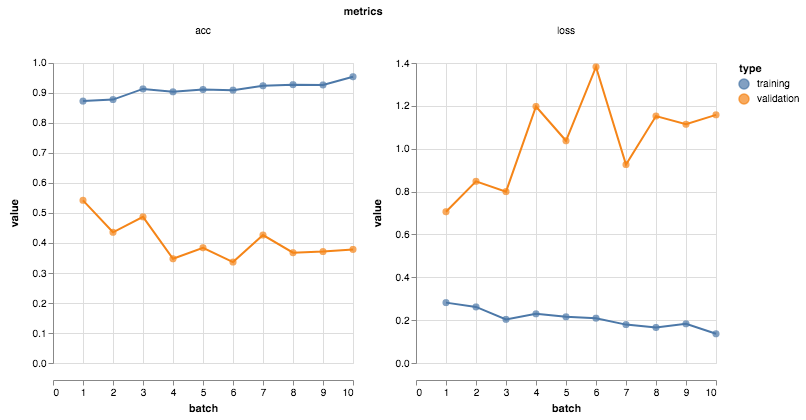

In [17]:
vis.metrics(m_metrics)

## Fine Tuning a Transfer Learning Model

Retrain the last 3 layers of base model with image augmentation

In [18]:
for layer in m.layers[:47]:
   layer.trainable = False
for layer in m.layers[47:]:
   layer.trainable = True

In [19]:
m.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

In [ ]:
m_output_trainable =  m.fit_generator(train_generator, epochs=10, steps_per_epoch=1000 // 8,
                            validation_data=val_generator, validation_steps=600 // 8,
                            verbose = 1)

Epoch 1/10
125/125 [==============================] - 49s 391ms/step - loss: 0.1734 - acc: 0.9290 - val_loss: 0.6892 - val_acc: 0.5680
Epoch 2/10
125/125 [==============================] - 42s 337ms/step - loss: 0.1346 - acc: 0.9470 - val_loss: 2.0037 - val_acc: 0.3217
Epoch 3/10
125/125 [==============================] - 42s 338ms/step - loss: 0.0871 - acc: 0.9640 - val_loss: 5.0807 - val_acc: 0.3272
Epoch 4/10
125/125 [==============================] - 42s 337ms/step - loss: 0.0805 - acc: 0.9700 - val_loss: 1.3968 - val_acc: 0.3199
Epoch 5/10
125/125 [==============================] - 42s 333ms/step - loss: 0.0831 - acc: 0.9720 - val_loss: 0.6649 - val_acc: 0.6103
Epoch 6/10
125/125 [==============================] - 42s 335ms/step - loss: 0.0517 - acc: 0.9840 - val_loss: 0.9899 - val_acc: 0.3290
Epoch 7/10
125/125 [==============================] - 42s 336ms/step - loss: 0.0377 - acc: 0.9880 - val_loss: 0.9633 - val_acc: 0.3290
Epoch 8/10
124/125 [============================>.] - E

In [ ]:
vis.metrics(m_output_trainable.history)